In [1]:
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils.GNN_data import *
from utils.GNN_model import GIN
from utils.train_model import train_model
from utils.evaluate_model import *

## Define input variables

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--Rock', type=str, default='B1_B2_FB1_FB2', help='rock image in dataset')
parser.add_argument('--Unseen_Rock', type=str, default='CG', help='unseen rock image')
parser.add_argument('--batch_num', type=int, default=64, help='batch size') 
parser.add_argument('--epoch_num', type=int, default=200, help='Epoch number') 
parser.add_argument('--avg_scheme', choices=['Voigt', 'Hill'], default='Voigt')
parser.add_argument('--cover_interval', type=int, default=20, help='Cover interval')
parser.add_argument('--overlap', type=float, default=0.3, help='cover overlap')
parser.add_argument('--excluded_subcube', type=str, default='150', help='excluded subcube')
parser.add_argument('--unseen_subcube_size', type=str, default='90_100_180', help='excluded subcube size')
parser.add_argument('--save_model_dir', type=str, default='./examples/saved_GNN_model', help='saved GNN model directory')
args = parser.parse_args([])

In [3]:
batch_size = args.batch_num 
epoch_num = args.epoch_num 
overlap=args.overlap
learning_rate = 0.005

# combined 4 rocks (B1, B2, FB1, FB2) with regular interval
data_dir = f'./examples/graph_data/{args.Rock}_DFS_CoverInterval_{args.cover_interval}_Overlap_{overlap}_except_subcube{args.excluded_subcube}.pkl'

## Load data and perform data pre-processing

In [4]:
# Load data
data_list = load_data(data_dir)

# Apply the selected material averaging scheme to the dataset
data_list = Elastic_property_avg_scheme(data_list, args.avg_scheme)

# Check if the graph data is directed or undirected. For this study, undirected edges are used.
all_undirected_before = all(is_undirected(data) for data in data_list)
print(f'Graphs are undirected (before conversion): {all_undirected_before}')  # True if all are undirected, False otherwise

# Convert all graphs in the dataset to undirected
data_list = [make_undirected(data) for data in data_list]

# Re-check if all graphs are now undirected
all_undirected_after = all(is_undirected(data) for data in data_list)
print(f'Graphs are undirected (after conversion): {all_undirected_after}')  # True if all are undirected, False otherwise

# Normalize the spatial features in nodes
data_list = normalize_spatial_info(data_list)

# Augment data
data_list = augment_dataset(data_list)

# Split dataset for train/validation/test
train_loader, test_loader, valid_loader = prepare_dataset(data_list, batch_size, train_percentage=0.80, test_percentage=0.1)

Graphs are undirected (before conversion): False
Graphs are undirected (after conversion): True
Number of training graphs: 41529
Number of test graphs: 5191
Number of vali graphs: 5192


In [5]:
data_list[0].x[:1,6]

tensor([16.4021])

## Define GNN architecture

In [6]:
# Define the model, optimizer, and loss function
no_node_feature = data_list[0].x.shape[1]
model = GIN(dim_h=16, node_feature=no_node_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=48, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin4): Linear(in_features=32, 

## Train model

In [7]:
train_losses, test_losses, R2_trainings, R2_tests, train_acc_total, test_acc_total, best_state_dict = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device=device, num_epochs=epoch_num)

Epoch [1/200], Loss[Train: 327.303, Test: 61.419], R2[train K: -2.070, test K: 0.508, train mu: -1.214, test mu: 0.539], acc[train K: 67.11, test K: 84.71, train mu: 66.05, test mu: 82.03]
Epoch [2/200], Loss[Train: 10.998, Test: 4.120], R2[train K: 0.907, test K: 0.965, train mu: 0.920, test mu: 0.970], acc[train K: 93.48, test K: 95.60, train mu: 92.30, test mu: 94.90]
Epoch [3/200], Loss[Train: 4.053, Test: 4.158], R2[train K: 0.966, test K: 0.963, train mu: 0.971, test mu: 0.971], acc[train K: 95.66, test K: 95.37, train mu: 94.92, test mu: 94.90]
Epoch [4/200], Loss[Train: 3.770, Test: 3.177], R2[train K: 0.968, test K: 0.974, train mu: 0.973, test mu: 0.976], acc[train K: 95.79, test K: 96.21, train mu: 95.10, test mu: 95.46]
Epoch [5/200], Loss[Train: 3.523, Test: 3.025], R2[train K: 0.970, test K: 0.974, train mu: 0.974, test mu: 0.978], acc[train K: 95.98, test K: 96.14, train mu: 95.33, test mu: 95.52]
Epoch [6/200], Loss[Train: 3.258, Test: 3.390], R2[train K: 0.973, test K:

Epoch [45/200], Loss[Train: 2.028, Test: 1.982], R2[train K: 0.983, test K: 0.983, train mu: 0.985, test mu: 0.986], acc[train K: 96.93, test K: 96.97, train mu: 96.45, test mu: 96.52]
Epoch [46/200], Loss[Train: 2.032, Test: 2.022], R2[train K: 0.983, test K: 0.983, train mu: 0.985, test mu: 0.985], acc[train K: 96.92, test K: 96.93, train mu: 96.44, test mu: 96.38]
Epoch [47/200], Loss[Train: 2.021, Test: 1.874], R2[train K: 0.983, test K: 0.984, train mu: 0.985, test mu: 0.987], acc[train K: 96.93, test K: 97.02, train mu: 96.45, test mu: 96.56]
Epoch [48/200], Loss[Train: 2.080, Test: 2.096], R2[train K: 0.982, test K: 0.982, train mu: 0.985, test mu: 0.985], acc[train K: 96.89, test K: 96.86, train mu: 96.41, test mu: 96.41]
Epoch [49/200], Loss[Train: 2.014, Test: 1.755], R2[train K: 0.983, test K: 0.985, train mu: 0.986, test mu: 0.987], acc[train K: 96.93, test K: 97.15, train mu: 96.46, test mu: 96.69]
Epoch [50/200], Loss[Train: 2.021, Test: 1.905], R2[train K: 0.983, test K:

Epoch [89/200], Loss[Train: 1.673, Test: 1.575], R2[train K: 0.986, test K: 0.986, train mu: 0.988, test mu: 0.989], acc[train K: 97.22, test K: 97.27, train mu: 96.79, test mu: 96.88]
Epoch [90/200], Loss[Train: 1.673, Test: 1.594], R2[train K: 0.986, test K: 0.986, train mu: 0.988, test mu: 0.989], acc[train K: 97.22, test K: 97.29, train mu: 96.79, test mu: 96.87]
Epoch [91/200], Loss[Train: 1.666, Test: 1.870], R2[train K: 0.986, test K: 0.984, train mu: 0.988, test mu: 0.987], acc[train K: 97.22, test K: 97.01, train mu: 96.80, test mu: 96.55]
Epoch [92/200], Loss[Train: 1.664, Test: 1.600], R2[train K: 0.986, test K: 0.986, train mu: 0.988, test mu: 0.989], acc[train K: 97.23, test K: 97.28, train mu: 96.80, test mu: 96.87]
Epoch [93/200], Loss[Train: 1.671, Test: 1.666], R2[train K: 0.986, test K: 0.986, train mu: 0.988, test mu: 0.988], acc[train K: 97.22, test K: 97.21, train mu: 96.80, test mu: 96.76]
Epoch [94/200], Loss[Train: 1.665, Test: 1.815], R2[train K: 0.986, test K:

Epoch [133/200], Loss[Train: 1.538, Test: 1.502], R2[train K: 0.987, test K: 0.987, train mu: 0.989, test mu: 0.989], acc[train K: 97.34, test K: 97.37, train mu: 96.94, test mu: 96.98]
Epoch [134/200], Loss[Train: 1.549, Test: 1.499], R2[train K: 0.987, test K: 0.987, train mu: 0.989, test mu: 0.989], acc[train K: 97.32, test K: 97.39, train mu: 96.92, test mu: 97.00]
Epoch [135/200], Loss[Train: 1.540, Test: 1.881], R2[train K: 0.987, test K: 0.984, train mu: 0.989, test mu: 0.987], acc[train K: 97.34, test K: 97.27, train mu: 96.94, test mu: 96.86]
Epoch [136/200], Loss[Train: 1.549, Test: 1.504], R2[train K: 0.987, test K: 0.987, train mu: 0.989, test mu: 0.989], acc[train K: 97.32, test K: 97.37, train mu: 96.92, test mu: 96.99]
Epoch [137/200], Loss[Train: 1.548, Test: 1.602], R2[train K: 0.987, test K: 0.986, train mu: 0.989, test mu: 0.989], acc[train K: 97.32, test K: 97.30, train mu: 96.92, test mu: 96.90]
Epoch [138/200], Loss[Train: 1.543, Test: 1.539], R2[train K: 0.987, t

Epoch 00177: reducing learning rate of group 0 to 7.8125e-05.
Epoch [177/200], Loss[Train: 1.502, Test: 1.491], R2[train K: 0.987, test K: 0.987, train mu: 0.989, test mu: 0.989], acc[train K: 97.37, test K: 97.40, train mu: 96.98, test mu: 97.02]
Epoch [178/200], Loss[Train: 1.487, Test: 1.480], R2[train K: 0.987, test K: 0.987, train mu: 0.989, test mu: 0.989], acc[train K: 97.39, test K: 97.41, train mu: 97.00, test mu: 97.02]
Epoch [179/200], Loss[Train: 1.490, Test: 1.478], R2[train K: 0.987, test K: 0.987, train mu: 0.989, test mu: 0.989], acc[train K: 97.38, test K: 97.41, train mu: 96.99, test mu: 97.03]
Epoch [180/200], Loss[Train: 1.485, Test: 1.506], R2[train K: 0.987, test K: 0.987, train mu: 0.989, test mu: 0.989], acc[train K: 97.39, test K: 97.38, train mu: 97.00, test mu: 96.98]
Epoch [181/200], Loss[Train: 1.487, Test: 1.478], R2[train K: 0.987, test K: 0.987, train mu: 0.989, test mu: 0.989], acc[train K: 97.39, test K: 97.41, train mu: 97.00, test mu: 97.03]
Epoch [1

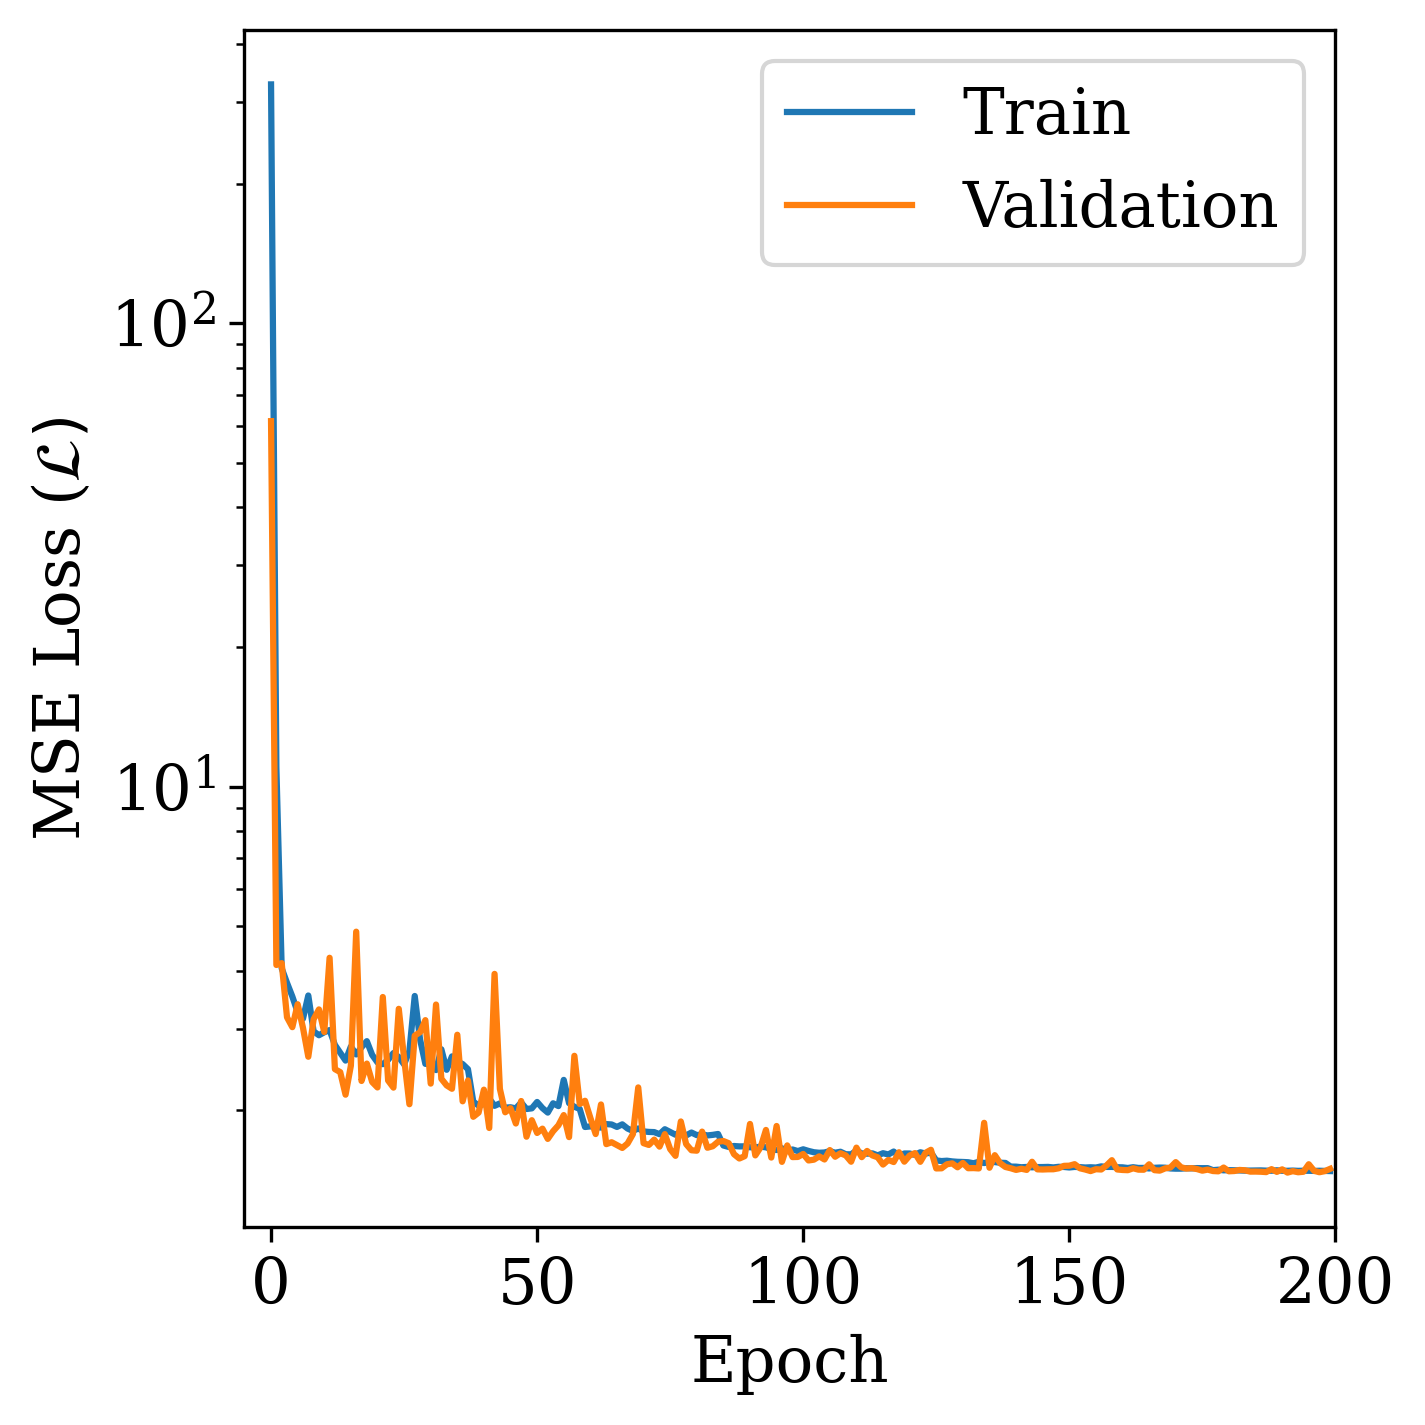

In [8]:
# 1) Epoch vs R^2
plt.figure(dpi=300, figsize=(5,5)) 

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 15

plt.plot(np.array(train_losses), label='Train')
plt.plot(np.array(test_losses), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'MSE Loss ($\mathcal{L})$')
plt.yscale("log") 
plt.xlim(-5,args.epoch_num)
plt.tight_layout() 
plt.savefig(f'{args.save_model_dir}/epoch_{args.epoch_num}.png')

## Save model

In [18]:
best_model_path = f'{args.save_model_dir}/epoch_{args.epoch_num}.pt'  
torch.save(best_state_dict, best_model_path)

## Evaluate model for the test dataset

Test MSE for K: 0.9871245194298164 for mu: 0.9893215912009807, for avg: 0.9882230553153986
Accuracy for K 97.32673
Accuracy for mu 96.90875


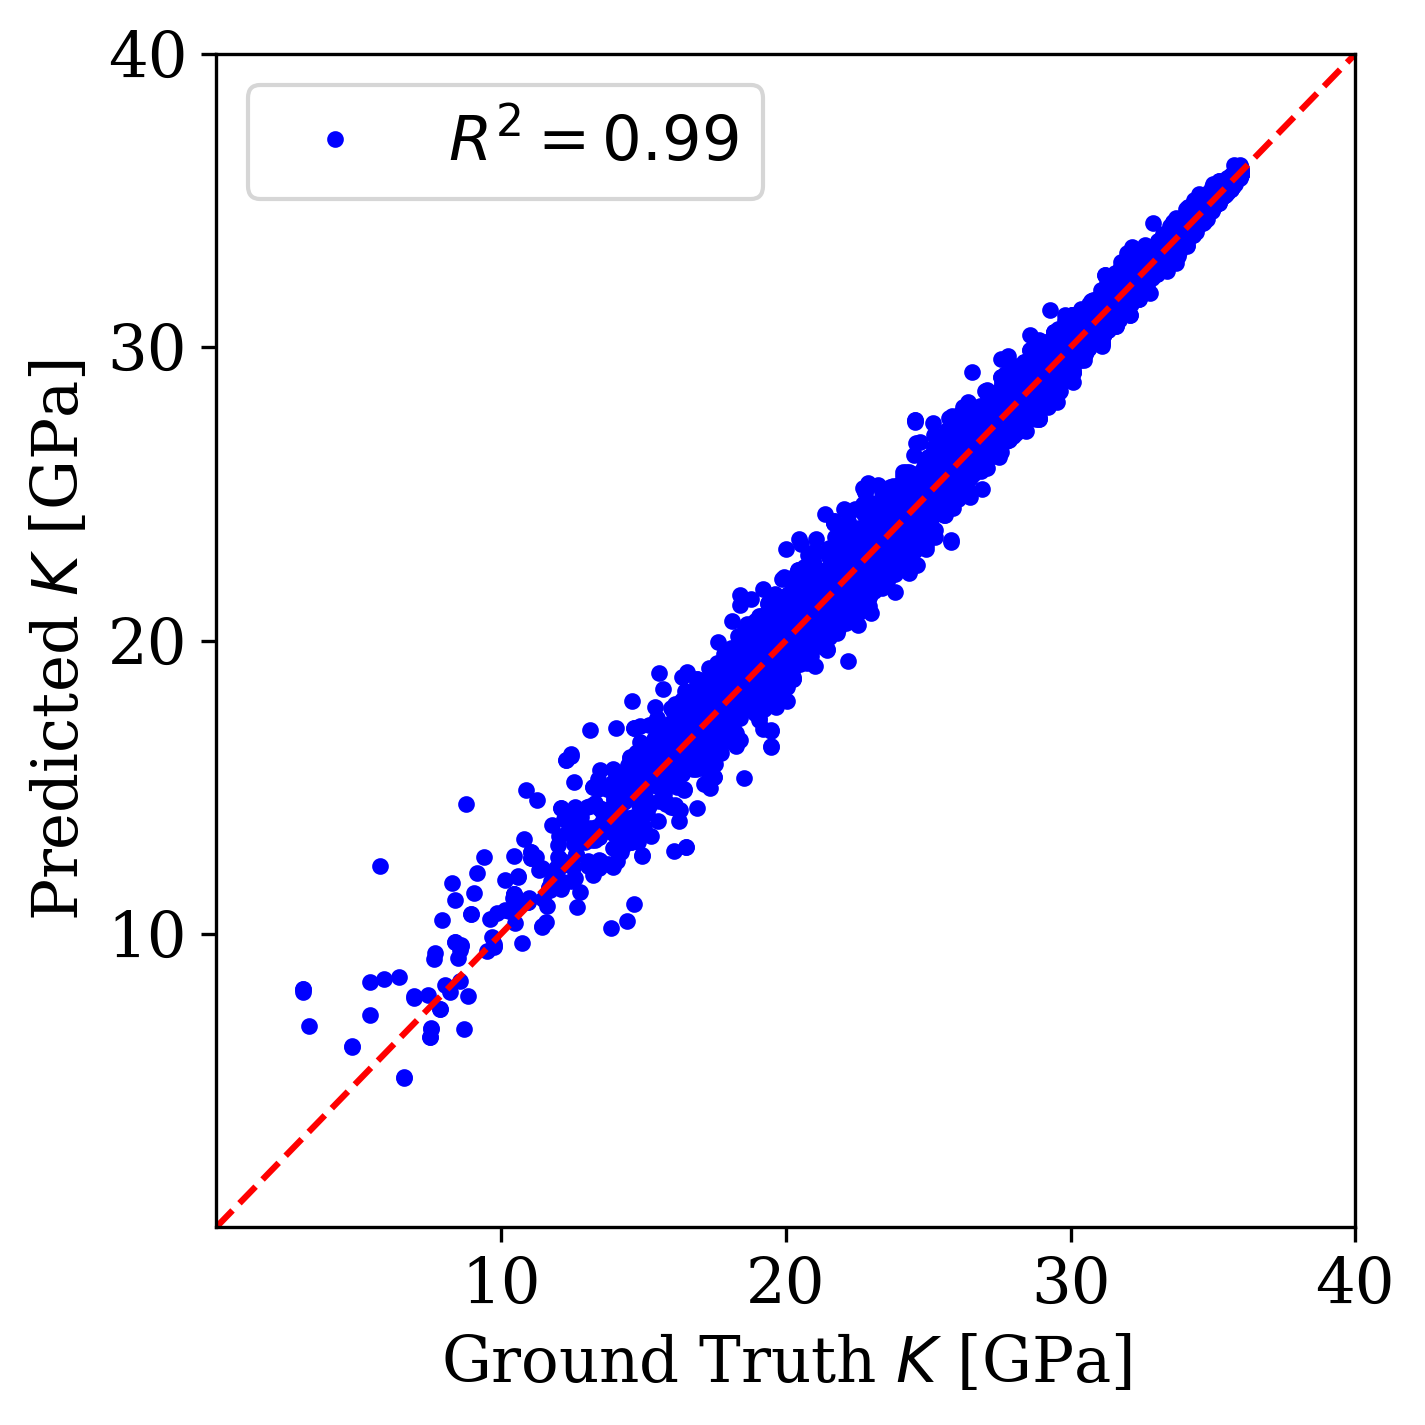

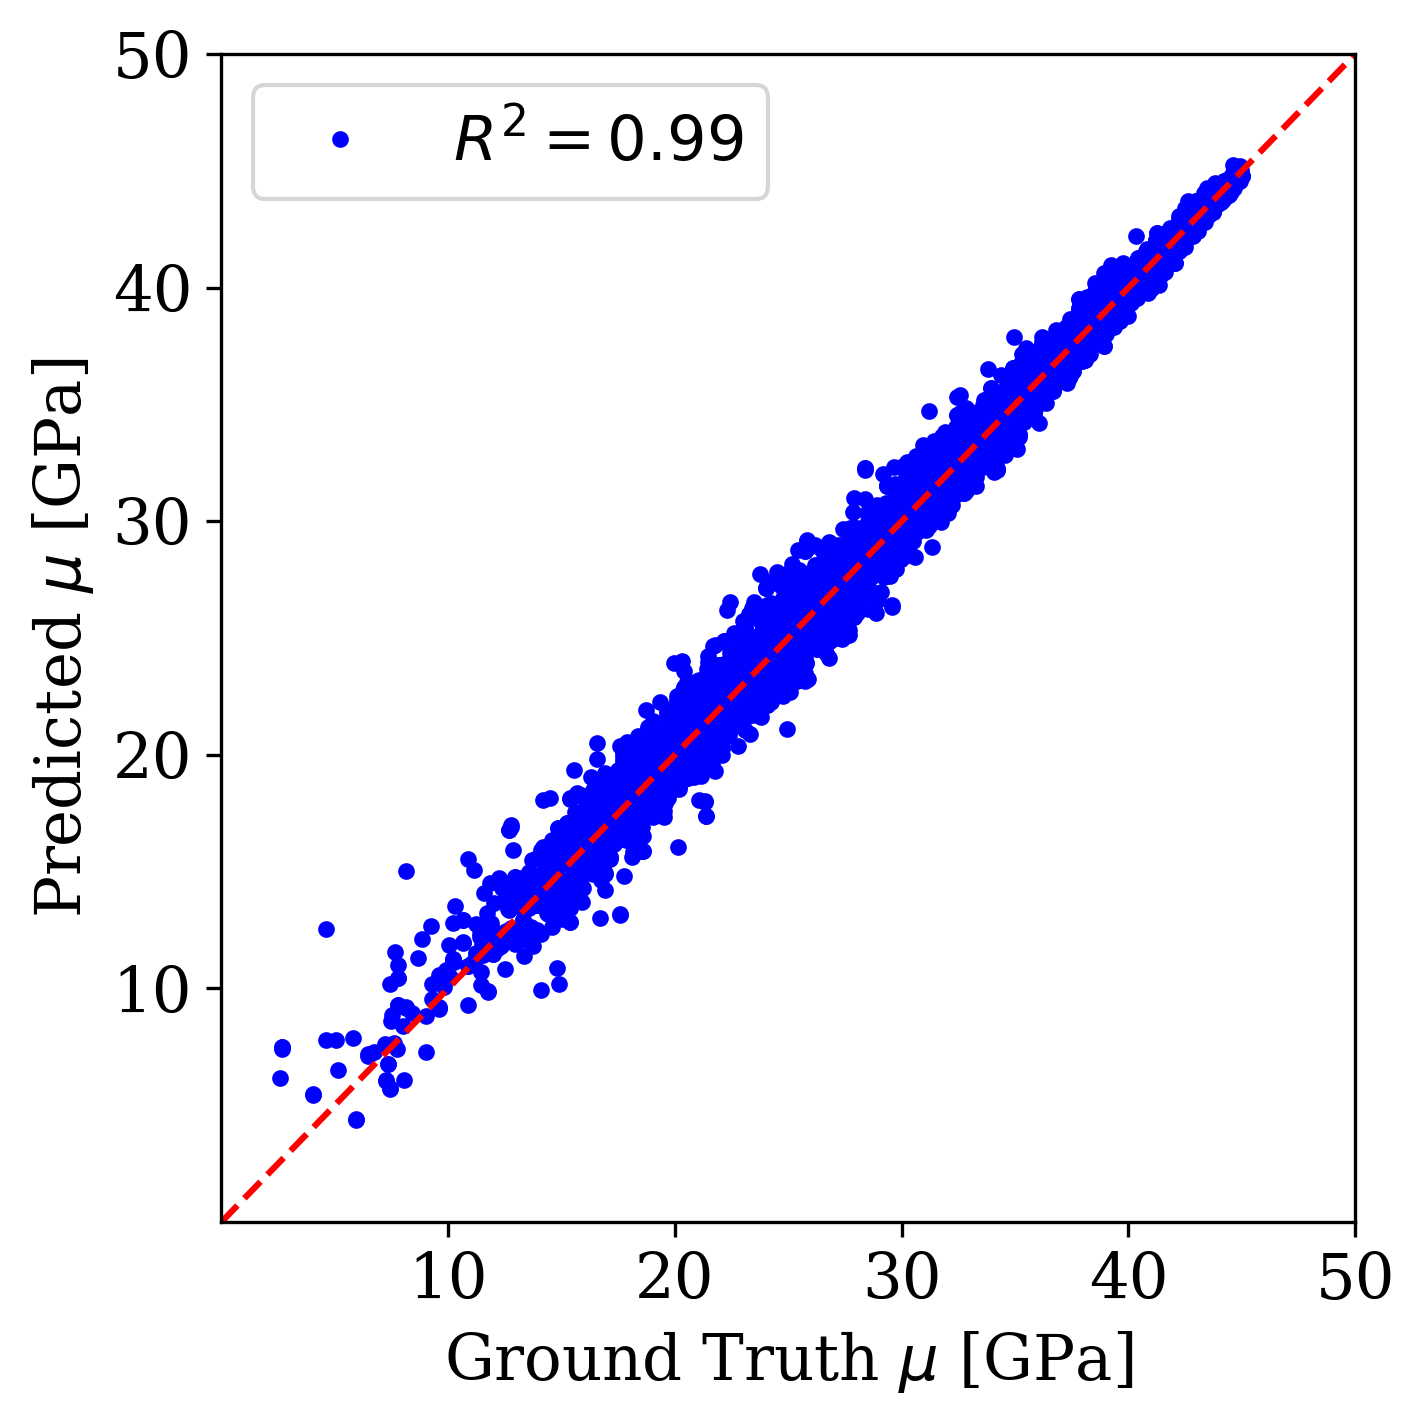

In [9]:
R2_K, R2_mu = evaluate_model(model, valid_loader, device, args.Rock, args.cover_interval, overlap, args.excluded_subcube, args.save_model_dir)

## Evaludate model for the unseen rock dataset (CG sandstone)

unseen rock data dir: ./examples/graph_data/CG_DFS_CoverInterval_20_Overlap_0.3_except_subcube150.pkl
Number of training graphs: 18
Number of test graphs: 18
Number of vali graphs: 1818
Test MSE for K: 0.927338691167197 for mu: 0.9368391625041141, for avg: 0.9320889268356556
Accuracy for K 95.62414
Accuracy for mu 95.12239


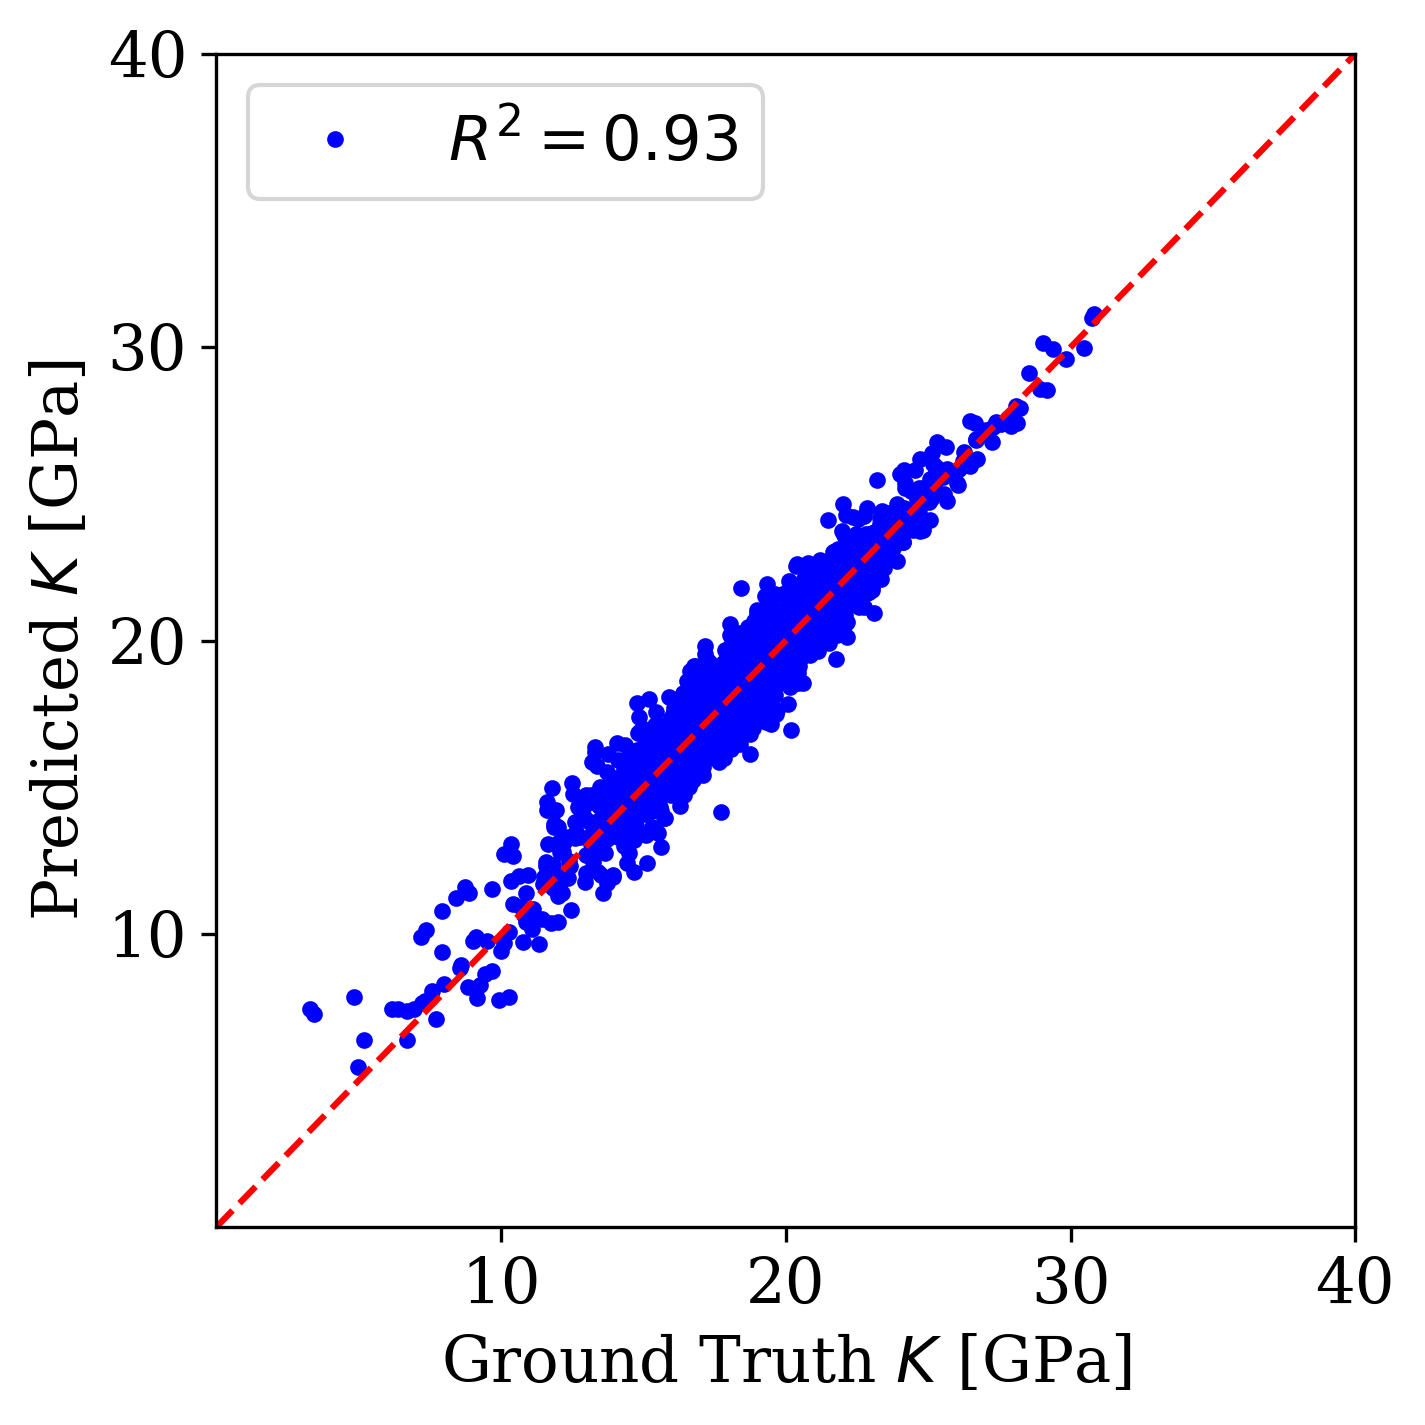

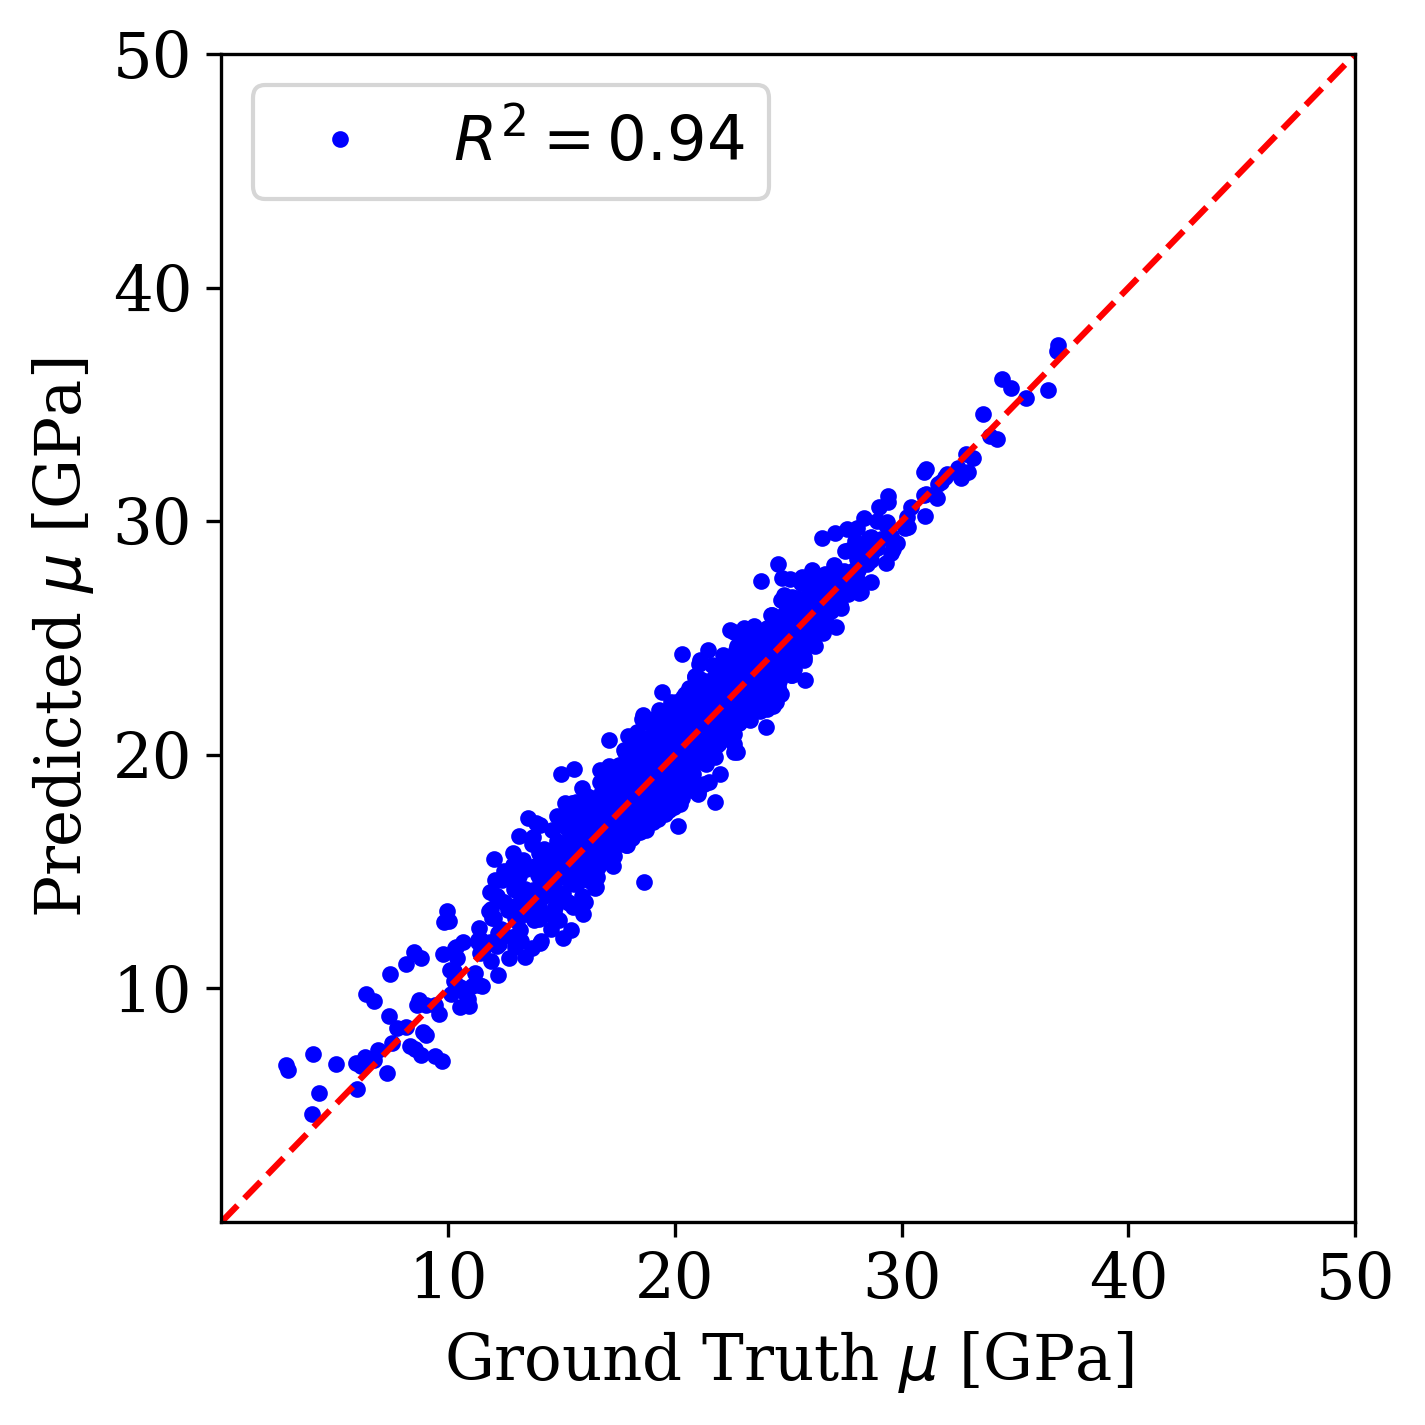

In [17]:
# Load unseen rock
unseen_rock_data_dir = f'./examples/graph_data/{args.Unseen_Rock}_DFS_CoverInterval_{args.cover_interval}_Overlap_{overlap}_except_subcube{args.excluded_subcube}.pkl'
print(f'unseen rock data dir: {unseen_rock_data_dir}') 
# Load data & Apply the selected material averaging scheme to the dataset
unseen_rock_data_list = Elastic_property_avg_scheme(load_data(unseen_rock_data_dir), args.avg_scheme)
# Convert all graphs in the dataset to undirected
unseen_rock_data_list = [make_undirected(data) for data in unseen_rock_data_list]
# Normalize the spatial features in nodes
unseen_rock_data_list = normalize_spatial_info(unseen_rock_data_list)
# Split dataset for train/validation/test
unseen_rock_train_loader, unseen_rock_test_loader, unseen_rock_valid_loader = prepare_dataset(unseen_rock_data_list, batch_size, train_percentage=0.01, test_percentage=0.01)
R2_K, R2_mu = evaluate_model(model, unseen_rock_valid_loader, device, args.Unseen_Rock, args.cover_interval, args.overlap, args.excluded_subcube, args.save_model_dir)

## Evaluate model for the unseen subcube size dataset (subcube size 150)
- Subcube sizes for the training dataset: 90, 100, 180 

unseen rock data dir: ./examples/graph_data/B1_B2_FB1_FB2_DFS_CoverInterval_20_Overlap_0.3_except_subcube90_100_180.pkl
Number of training graphs: 8
Number of test graphs: 8
Number of vali graphs: 848
Test MSE for K: 0.9837023496422365 for mu: 0.9852094339375846, for avg: 0.9844558917899106
Accuracy for K 97.30527
Accuracy for mu 96.799904


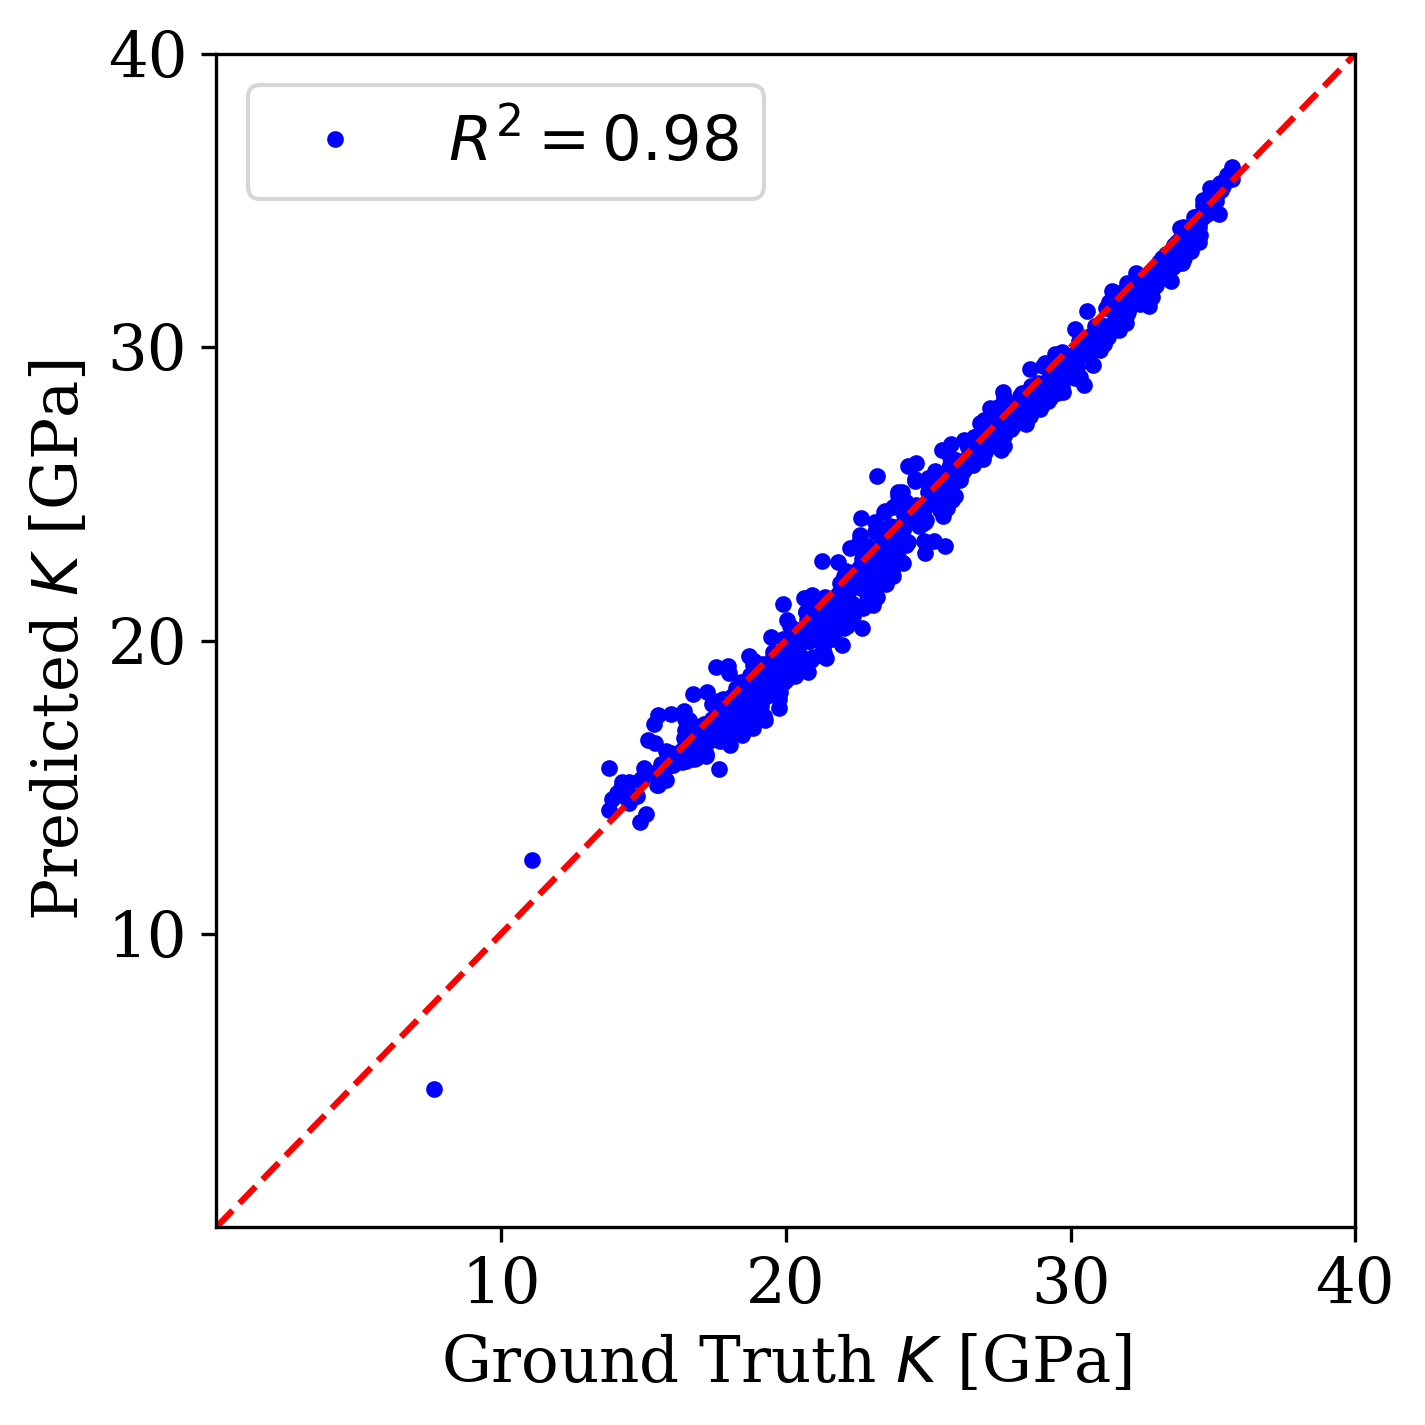

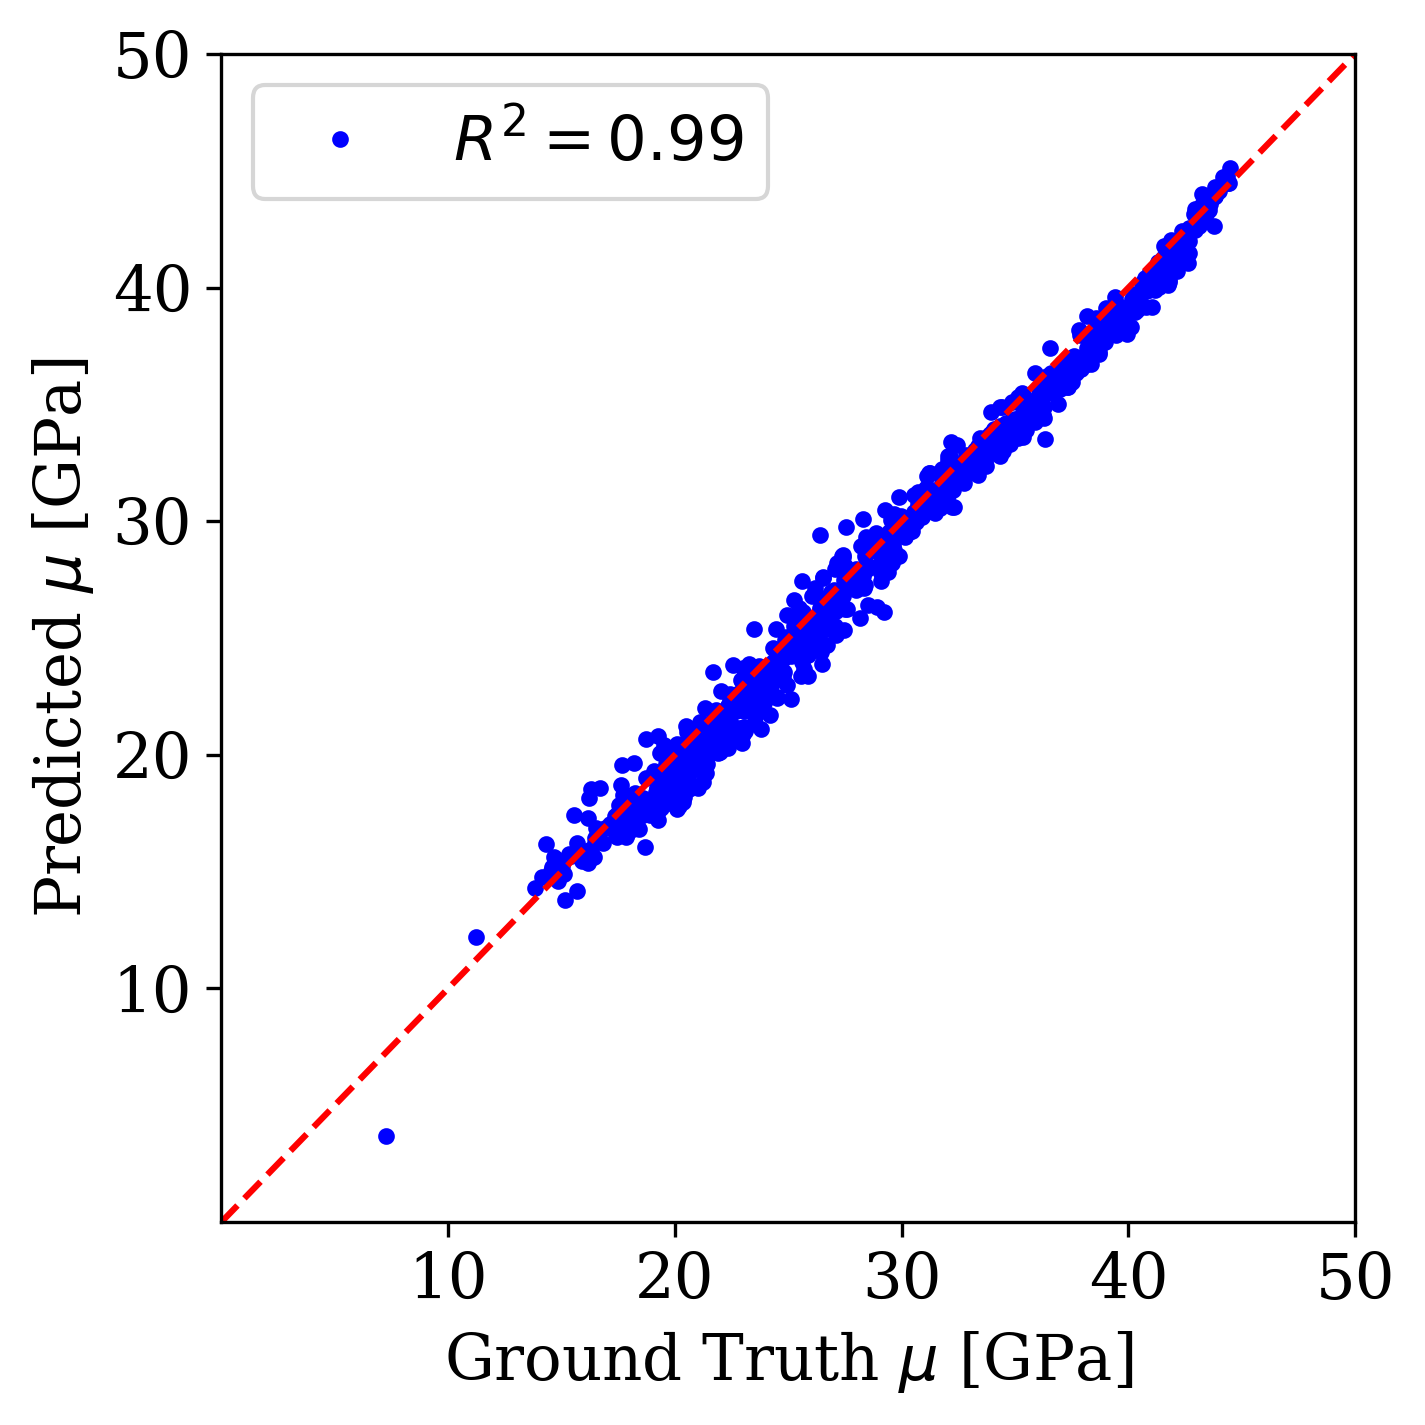

In [16]:
# Load unseen rock
unseen_subcube_data_dir = f'./examples/graph_data/{args.Rock}_DFS_CoverInterval_{args.cover_interval}_Overlap_{overlap}_except_subcube{args.unseen_subcube_size}.pkl'
print(f'unseen rock data dir: {unseen_subcube_data_dir}') 
# Load data & Apply the selected material averaging scheme to the dataset
unseen_subcube_data_list = Elastic_property_avg_scheme(load_data(unseen_subcube_data_dir), args.avg_scheme)
# Convert all graphs in the dataset to undirected
unseen_subcube_data_list = [make_undirected(data) for data in unseen_subcube_data_list]
# # Normalize the spatial features in nodes
unseen_subcube_data_list = normalize_spatial_info(unseen_subcube_data_list)
# # Split dataset for train/validation/test
unseen_subcube_train_loader, unseen_subcube_test_loader, unseen_subcube_valid_loader = prepare_dataset(unseen_subcube_data_list, batch_size, train_percentage=0.01, test_percentage=0.01)
R2_K, R2_mu = evaluate_model(model, unseen_subcube_valid_loader, device, args.Unseen_Rock, args.cover_interval, args.overlapargs.unseen_subcube_size, args.save_model_dir)
